In [10]:
import nfl_data_py as nfl
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tqdm

In [11]:
# Fetch play-by-play data for multiple seasons
seasons = range(2018, 2024)  # Adjust the range as needed

pbp_data = nfl.import_pbp_data(seasons)
pbp_data_old = nfl.import_pbp_data([2015, 2016, 2017, 2024])

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.
2015 done.
2016 done.
2017 done.
2024 done.
Downcasting floats.


In [112]:
def filter_normalize_data(data):
    # Select relevant features for your state representation
    relevant_features = ['down', 'ydstogo', 'yardline_100', 'score_differential', 'qtr', 'time', 'posteam', 'defteam', 'play_type', 'offense_formation', 'offense_personnel', 'defense_personnel', 'defenders_in_box']
    filtered_data = data[relevant_features].dropna()

    scaler = MinMaxScaler()
    filtered_data['yardline_100_normalized'] = scaler.fit_transform(filtered_data[['yardline_100']])
    le = LabelEncoder()
    filtered_data['posteam_transformed'] = le.fit_transform(filtered_data['posteam'])
    filtered_data['defteam_transformed'] = le.fit_transform(filtered_data['defteam'])
    filtered_data['score_differential_normalized'] = scaler.fit_transform(filtered_data[['score_differential']])

    # only keep plays that are either a pass or a run
    filtered_data = filtered_data[filtered_data['play_type'].isin(['pass', 'run'])]

    def time_to_seconds(time_str):
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds

    filtered_data['offense_formation_normalized'] = le.fit_transform(filtered_data['offense_formation'])
    filtered_data['offense_personnel_normalized'] = le.fit_transform(filtered_data['offense_personnel'])
    filtered_data['defense_personnel_normalized'] = le.fit_transform(filtered_data['defense_personnel'])
    filtered_data['defenders_in_box_normalized'] = scaler.fit_transform(filtered_data[['defenders_in_box']])

    filtered_data['time_normalized'] = filtered_data['time'].apply(time_to_seconds)

    # Step 2: Normalize the `time_seconds` column
    filtered_data['time_normalized'] = filtered_data['time_normalized'] / 900

    # convert quarter to boolean if it is the 4th quarter/2nd quarter
    filtered_data['qtr_clock_matters'] = filtered_data['qtr'].apply(lambda x: x not in [1, 3])

    return filtered_data

filtered_data = filter_normalize_data(pbp_data)
filtered_data_old = filter_normalize_data(pbp_data_old)
action_space = ['short left pass', 'deep left pass', 'short middle pass', 'deep middle pass', 'short right pass', 'deep right pass', 'end left run', 'guard left run', 'tackle left run', 'end right run', 'guard right run', 'tackle right run', 'end middle run', 'guard middle run', 'tackle middle run']

In [137]:
import numpy as np

class NFLEnvironment:
    def __init__(self, data, test=False):
        self.data = data
        self.current_index = np.random.randint(0, len(data))
        self.test = test
        if self.test:
            self.current_index = 0

    def reset(self):
        self.current_index = np.random.randint(0, len(self.data))
        if self.test:
            self.current_index = 0
        return self._get_state()

    def step(self, action):
        reward = self._calculate_reward(action)
        if self.test:        
            self.current_index += 1
        else:
            self.current_index = np.random.randint(0, len(self.data))
        done = self.current_index >= len(self.data)
        state = self._get_state()
        return state, reward, done, {}

    def _get_state(self):
        try:
            val_to_return = self.data.iloc[self.current_index][['down', 'ydstogo', 'yardline_100_normalized', 'score_differential_normalized', 'qtr_clock_matters', 'time_normalized', 'offense_personnel_normalized']].values.astype(float)
            return val_to_return
        except IndexError:
            print(self.current_index)
            return None

    def _calculate_reward(self, action, yards_predicted=None):
        # run -> run_location + run_gap + play_type
        # pass -> pass_location + pass_length + play_type
        row = self.data.iloc[self.current_index]

        # true_play = self.data.iloc[self.current_index]['play_type']
        # action = 'pass' if action == 1 else 'run'
        # return 1 if action == true_play else -1

        reward = 0

        base_play = row['play_type']
        pred_play = action_space[action]

        if base_play == 'run':
            true_play = row['run_location'] + ' ' + row['run_gap'] + ' ' + 'run'
        else:
            true_play = row['pass_location'] + ' ' + row['pass_length'] + ' ' + 'pass'


        # 2 -> play type, 1 -> position/direction, 0 -> 

        true_play_components = [row['run_location'], row['run_gap'], 'run'] if base_play == 'run' else [row['pass_location'], row['pass_length'], 'pass']
        pred_play_components = pred_play.split(' ')


        # yards_error = abs(yards_predicted - row['yards_gained'])
        # yards_reward = max(10-yards_error, -5)
        # if play type is correct -> 5, and you can't score negative
        # if location is correct 


        play_type_reward = 5 if action == true_play else -5

        if action in base_play:
            play_type_reward = max(play_type_reward, 0)
        else:
            play_type_reward -= 2


        # give a reward based on how close play is to true play, with a bonus for correct play type and deep ruuns


        return play_type_reward

In [138]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [139]:
class PPO:
    def __init__(self, env, policy_net, value_net, learning_rate=3e-4, clip_epsilon=0.2):
        self.env = env
        self.policy_net = policy_net
        self.value_net = value_net
        self.optimizer = torch.optim.Adam(list(policy_net.parameters()) + list(value_net.parameters()), lr=learning_rate)
        self.clip_epsilon = clip_epsilon
        self.ppo_epochs = 10
        self.rewards_list = []

    def collect_trajectories(self, num_steps):
        states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []
        state = self.env.reset()
        
        for _ in range(num_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = self.x(state_tensor)
            value = self.value_net(state_tensor)
            
            action = torch.multinomial(action_probs, 1).item()
            log_prob = torch.log(action_probs[0, action])
            
            next_state, reward, done, _ = self.env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            log_probs.append(log_prob)
            values.append(value)
            
            state = next_state
            if done:
                state = self.env.reset()
        
        return states, actions, rewards, dones, log_probs, values

    def update(self, states, actions, rewards, dones, old_log_probs, old_values):
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        old_log_probs = torch.stack(old_log_probs)
        old_values = torch.cat(old_values)

        # Compute returns and advantages
        returns = self.compute_returns(rewards, dones)
        advantages = returns - old_values

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update loop
        for _ in range(self.ppo_epochs):
            states = states.detach()
            actions = actions.detach()
            old_log_probs = old_log_probs.detach()
            advantages = advantages.detach()
            returns = returns.detach()
            
            # Get new action probabilities and values
            new_action_probs = self.policy_net(states)
            new_values = self.value_net(states).squeeze()

            # Compute ratio and surrogate loss
            new_log_probs = torch.log(new_action_probs.gather(1, actions.unsqueeze(1))).squeeze()
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Compute value loss
            value_loss = nn.MSELoss()(new_values, returns)

            # Compute total loss
            loss = policy_loss + 0.5 * value_loss

            # Perform backpropagation and optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def compute_returns(self, rewards, dones, gamma=0.99):
        returns = []
        R = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + gamma * R * (1 - float(done))
            returns.insert(0, R)
        self.rewards_list.append(sum(rewards))
        return torch.FloatTensor(returns)

    def train(self, num_epochs, batch_size):
        self.ppo_epochs = num_epochs
        for epoch in tqdm.trange(num_epochs):
            trajectories = self.collect_trajectories(batch_size)
            self.update(*trajectories)

    def predict_play(self, state):
        with torch.no_grad():
            action_probs = self.policy_net(torch.FloatTensor(state))
        return action_probs.argmax().item()

In [140]:
# Evaluate the trained agent
def evaluate_agent(agent, env, num_plays=10000):
    correct_predictions = 0
    total_predictions = 0
    state = env.reset()

    for _ in tqdm.trange(num_plays):
        action = agent.predict_play(state)
        next_state, reward, _, _ = env.step(action)
        correct_predictions += (reward == 1)
        total_predictions += 1
        state = next_state

    accuracy = correct_predictions / total_predictions
    return accuracy

In [142]:
# Initialize environment and networks
action_space = ['short left pass', 'deep left pass', 'short middle pass', 'deep middle pass', 'short right pass', 'deep right pass', 'left end run', 'left guard run', 'left tackle run', 'right end run', 'right guard run', 'right tackle run', 'middle end run', 'middle guard run', 'middle tackle run']
action_space = ['run', 'pass']

def create_agent(learning_rate=3e-4, clip_epsilon=0.2):
    env = NFLEnvironment(filtered_data)
    state_dim = len(env._get_state())
    action_dim = len(action_space)

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)
    ppo_agent = PPO(env, policy_net, value_net, learning_rate=learning_rate, clip_epsilon=clip_epsilon)
    return env, ppo_agent


env, ppo_agent = create_agent()
# Create and train PPO agent
ppo_agent.train(num_epochs=50, batch_size=1024)
env = NFLEnvironment(filtered_data_old)
accuracy = evaluate_agent(ppo_agent, env, num_plays=30000)
print(f"Play prediction accuracy: {accuracy:.2f}")

# offense formation -> 62%
# offense personel -> 67%
# defense personel -> 61%
# defenders in box -> 61%

100%|██████████| 30000/30000 [00:07<00:00, 3876.05it/s]

Play prediction accuracy: 0.66


In [125]:
env = NFLEnvironment(filtered_data_old)
accuracy = evaluate_agent(ppo_agent, env, num_plays=10000)
print(f"Play prediction accuracy: {accuracy:.2f}")


100%|██████████| 10000/10000 [00:02<00:00, 3534.09it/s]

Play prediction accuracy: 0.64


In [ ]:
# plot rewards over time
ppo_agent_5 = create_agent()
ppo_agent_5.train(num_epochs=5, batch_size=1024)
ppo_agent_10 = create_agent()
ppo_agent_10.train(num_epochs=10, batch_size=1024)
ppo_agent_100 = create_agent()
ppo_agent_100.train(num_epochs=100, batch_size=1024)

In [87]:
# plot learning rate over time
_,ppo_agent_1e3 = create_agent(learning_rate=1e-3)
ppo_agent_1e3.train(num_epochs=100, batch_size=1024)
_, ppo_agent_3e4 = create_agent(learning_rate=3e-4)
ppo_agent_3e4.train(num_epochs=100, batch_size=1024)
_, ppo_agent_1e4 = create_agent(learning_rate=1e-4)
ppo_agent_1e4.train(num_epochs=100, batch_size=1024)
_, ppo_agent_3e5 = create_agent(learning_rate=3e-5)
ppo_agent_3e5.train(num_epochs=100, batch_size=1024)

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


In [ ]:
# plot batch size over time
ppo_agent_1024 = create_agent()
ppo_agent_1024.train(num_epochs=100, batch_size=1024)
ppo_agent_512 = create_agent()
ppo_agent_512.train(num_epochs=100, batch_size=512)
ppo_agent_2048 = create_agent()
ppo_agent_2048.train(num_epochs=100, batch_size=2048)

In [43]:
ppo_agent.predict_play([4, 1, 0.5, 0.5, 1, 0.5, 0, 1])

1

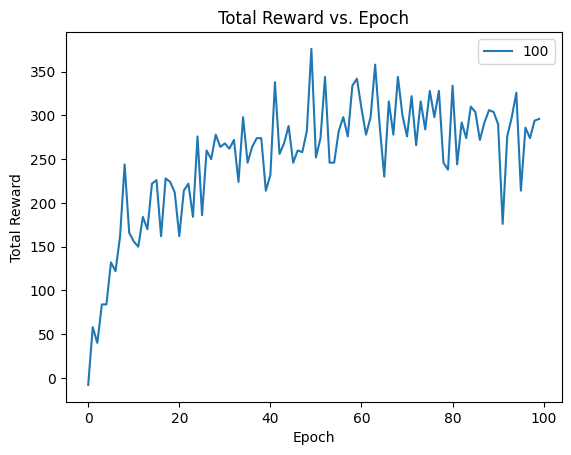

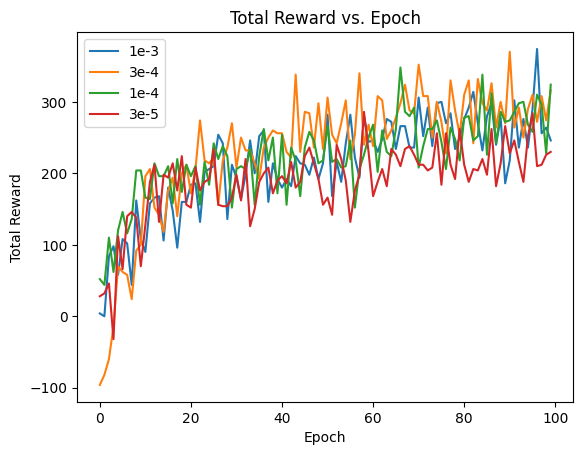

In [88]:
# plot rewards over time
import matplotlib.pyplot as plt

# plot a list of rewards
def plot_rewards(rewards, label):
    for i in range(len(rewards)):
        plt.plot(rewards[i], label=label[i])
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs. Epoch')
    plt.show()

plot_rewards([ppo_agent.rewards_list], ['100'])
plot_rewards([ppo_agent_1e3.rewards_list, ppo_agent_3e4.rewards_list, ppo_agent_1e4.rewards_list, ppo_agent_3e5.rewards_list], ['1e-3', '3e-4', '1e-4', '3e-5'])


207032
Down 1 accuracy: 0.55
Down 2 accuracy: 0.62
Down 3 accuracy: 0.80
Down 4 accuracy: 0.71


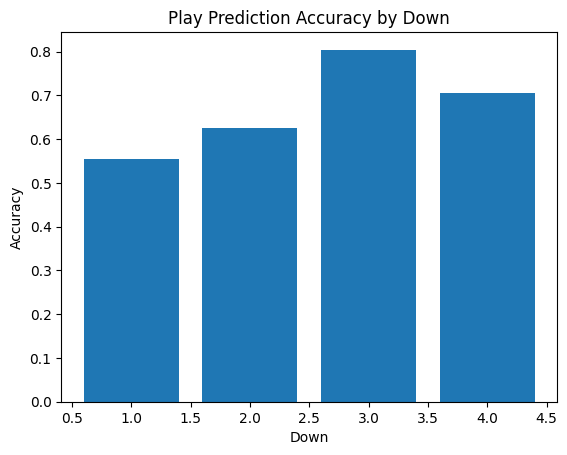

In [39]:
import matplotlib.pyplot as plt

# Analyze prediction accuracy by down
def analyze_by_down(agent, env):
    accuracies = {1: [], 2: [], 3: [], 4: []}
    state = env.reset()

    done = False
    while not done:  # Adjust number of plays to analyze
        down = env.data.iloc[env.current_index]['down']
        action = agent.predict_play(state)
        state, reward, done, _ = env.step(action)
        accuracies[down].append(reward == 1)

    for down, acc in accuracies.items():
        print(f"Down {down} accuracy: {sum(acc)/len(acc):.2f}")

    plt.bar(accuracies.keys(), [sum(acc)/len(acc) for acc in accuracies.values()])
    plt.title("Play Prediction Accuracy by Down")
    plt.xlabel("Down")
    plt.ylabel("Accuracy")
    plt.show()

analyze_by_down(ppo_agent, NFLEnvironment(filtered_data_old, test=True))

207032
Quarter 1 accuracy: 0.62
Quarter 2 accuracy: 0.66
Quarter 3 accuracy: 0.63
Quarter 4 accuracy: 0.70


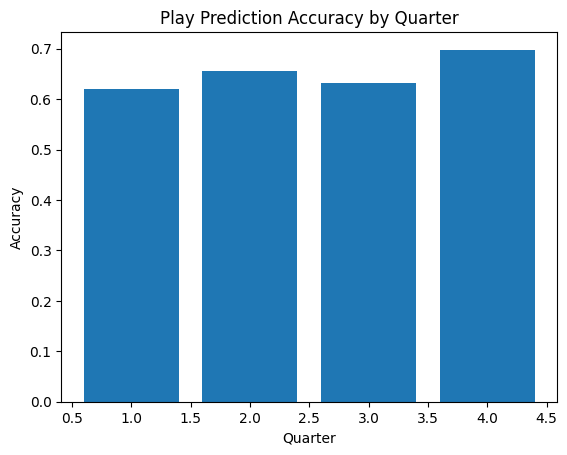

In [79]:
# Analyze prediction accuracy by quarter
def analyze_by_quarter(agent, env):
    accuracies = {1: [], 2: [], 3: [], 4: []}
    state = env.reset()

    done = False
    while not done:  # Adjust number of plays to analyze
        quarter = env.data.iloc[env.current_index]['qtr']
        action = agent.predict_play(state)
        state, reward, done, _ = env.step(action)
        if quarter <= 4:
            accuracies[quarter].append(reward == 1)

    for quarter, acc in accuracies.items():
        print(f"Quarter {quarter} accuracy: {sum(acc)/len(acc):.2f}")

    plt.rcdefaults()

    plt.bar(accuracies.keys(), [sum(acc)/len(acc) for acc in accuracies.values()])
    plt.title("Play Prediction Accuracy by Quarter")
    plt.xlabel("Quarter")
    plt.ylabel("Accuracy")
    plt.show()

analyze_by_quarter(ppo_agent, NFLEnvironment(filtered_data, test=True))

In [74]:
import matplotlib.pyplot as plt

# analyze by team, accuracy vs winning percentage over 2018-2024 seasons

# analyze by team (posteam)
def analyze_by_team(agent, env):
    accuracies = {}
    state = env.reset()

    done = False
    while not done:  # Adjust number of plays to analyze
        team = env.data.iloc[env.current_index]['posteam']
        action = agent.predict_play(state)
        state, reward, done, _ = env.step(action)
        if team not in accuracies:
            accuracies[team] = []
        accuracies[team].append(reward == 1)

    # for team, acc in accuracies.items():
    #     print(f"{team} accuracy: {sum(acc)/len(acc):.2f}")

    return accuracies

accuracies = analyze_by_team(ppo_agent, NFLEnvironment(filtered_data, test=True))

accuracies = {team: sum(acc)/len(acc) for team, acc in accuracies.items()}

207032


In [71]:
# Dependencies
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def resize_image(input_path, output_path, size=(50, 50)):
    img = Image.open(input_path)
    img = img.resize(size)
    img.save(output_path)
    
# Pull the team description 
logos = nfl.import_team_desc()

logos.head()

# Keep only the necessary columns in the logos DataFrame
logos = logos[['team_abbr', 'team_logo_espn']]
# Initialize an empty list for the logo file paths
logo_paths = []

# Initialize an empty list for the team abbreviations
team_abbr = []

# Create a folder for the image files if it doesn't exist

if not os.path.exists("logos"):
    os.makedirs("logos")
# Pull the team logos from the URL and save them in the logos folder, save the file paths to
for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos_resized/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])
# Create a dictionary to put logo_paths and team_abbr in
data = {'team_abbr' : team_abbr, 'Logo Path' : logo_paths}

# Create a DataFrame from the dictionary
logo_df = pd.DataFrame(data)

logo_df.head()

,team_abbr,Logo Path
0,ARI,logos_resized/ARI.tif
1,ATL,logos_resized/ATL.tif
2,BAL,logos_resized/BAL.tif
3,BUF,logos_resized/BUF.tif
4,CAR,logos_resized/CAR.tif


In [72]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(50, 50)):
    img = Image.open(input_path)
    img = img.resize(size)
    img.save(output_path)

# Example usage
input_directory = 'logos'
output_directory = 'logos_resized'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in os.listdir(input_directory):
    if filename.endswith('.tif'):
        resize_image(os.path.join(input_directory, filename), os.path.join(output_directory, filename))

Image size for logos_resized/ATL.tif: 50x50 pixels
Image size for logos_resized/PHI.tif: 50x50 pixels
Image size for logos_resized/BAL.tif: 50x50 pixels
Image size for logos_resized/BUF.tif: 50x50 pixels
Image size for logos_resized/GB.tif: 50x50 pixels
Image size for logos_resized/CHI.tif: 50x50 pixels
Image size for logos_resized/CIN.tif: 50x50 pixels
Image size for logos_resized/IND.tif: 50x50 pixels
Image size for logos_resized/DAL.tif: 50x50 pixels
Image size for logos_resized/CAR.tif: 50x50 pixels
Image size for logos_resized/NE.tif: 50x50 pixels
Image size for logos_resized/HOU.tif: 50x50 pixels
Image size for logos_resized/JAX.tif: 50x50 pixels
Image size for logos_resized/NYG.tif: 50x50 pixels
Image size for logos_resized/LAC.tif: 50x50 pixels
Image size for logos_resized/KC.tif: 50x50 pixels
Image size for logos_resized/LV.tif: 50x50 pixels
Image size for logos_resized/LA.tif: 50x50 pixels
Image size for logos_resized/NYJ.tif: 50x50 pixels
Image size for logos_resized/DET.tif

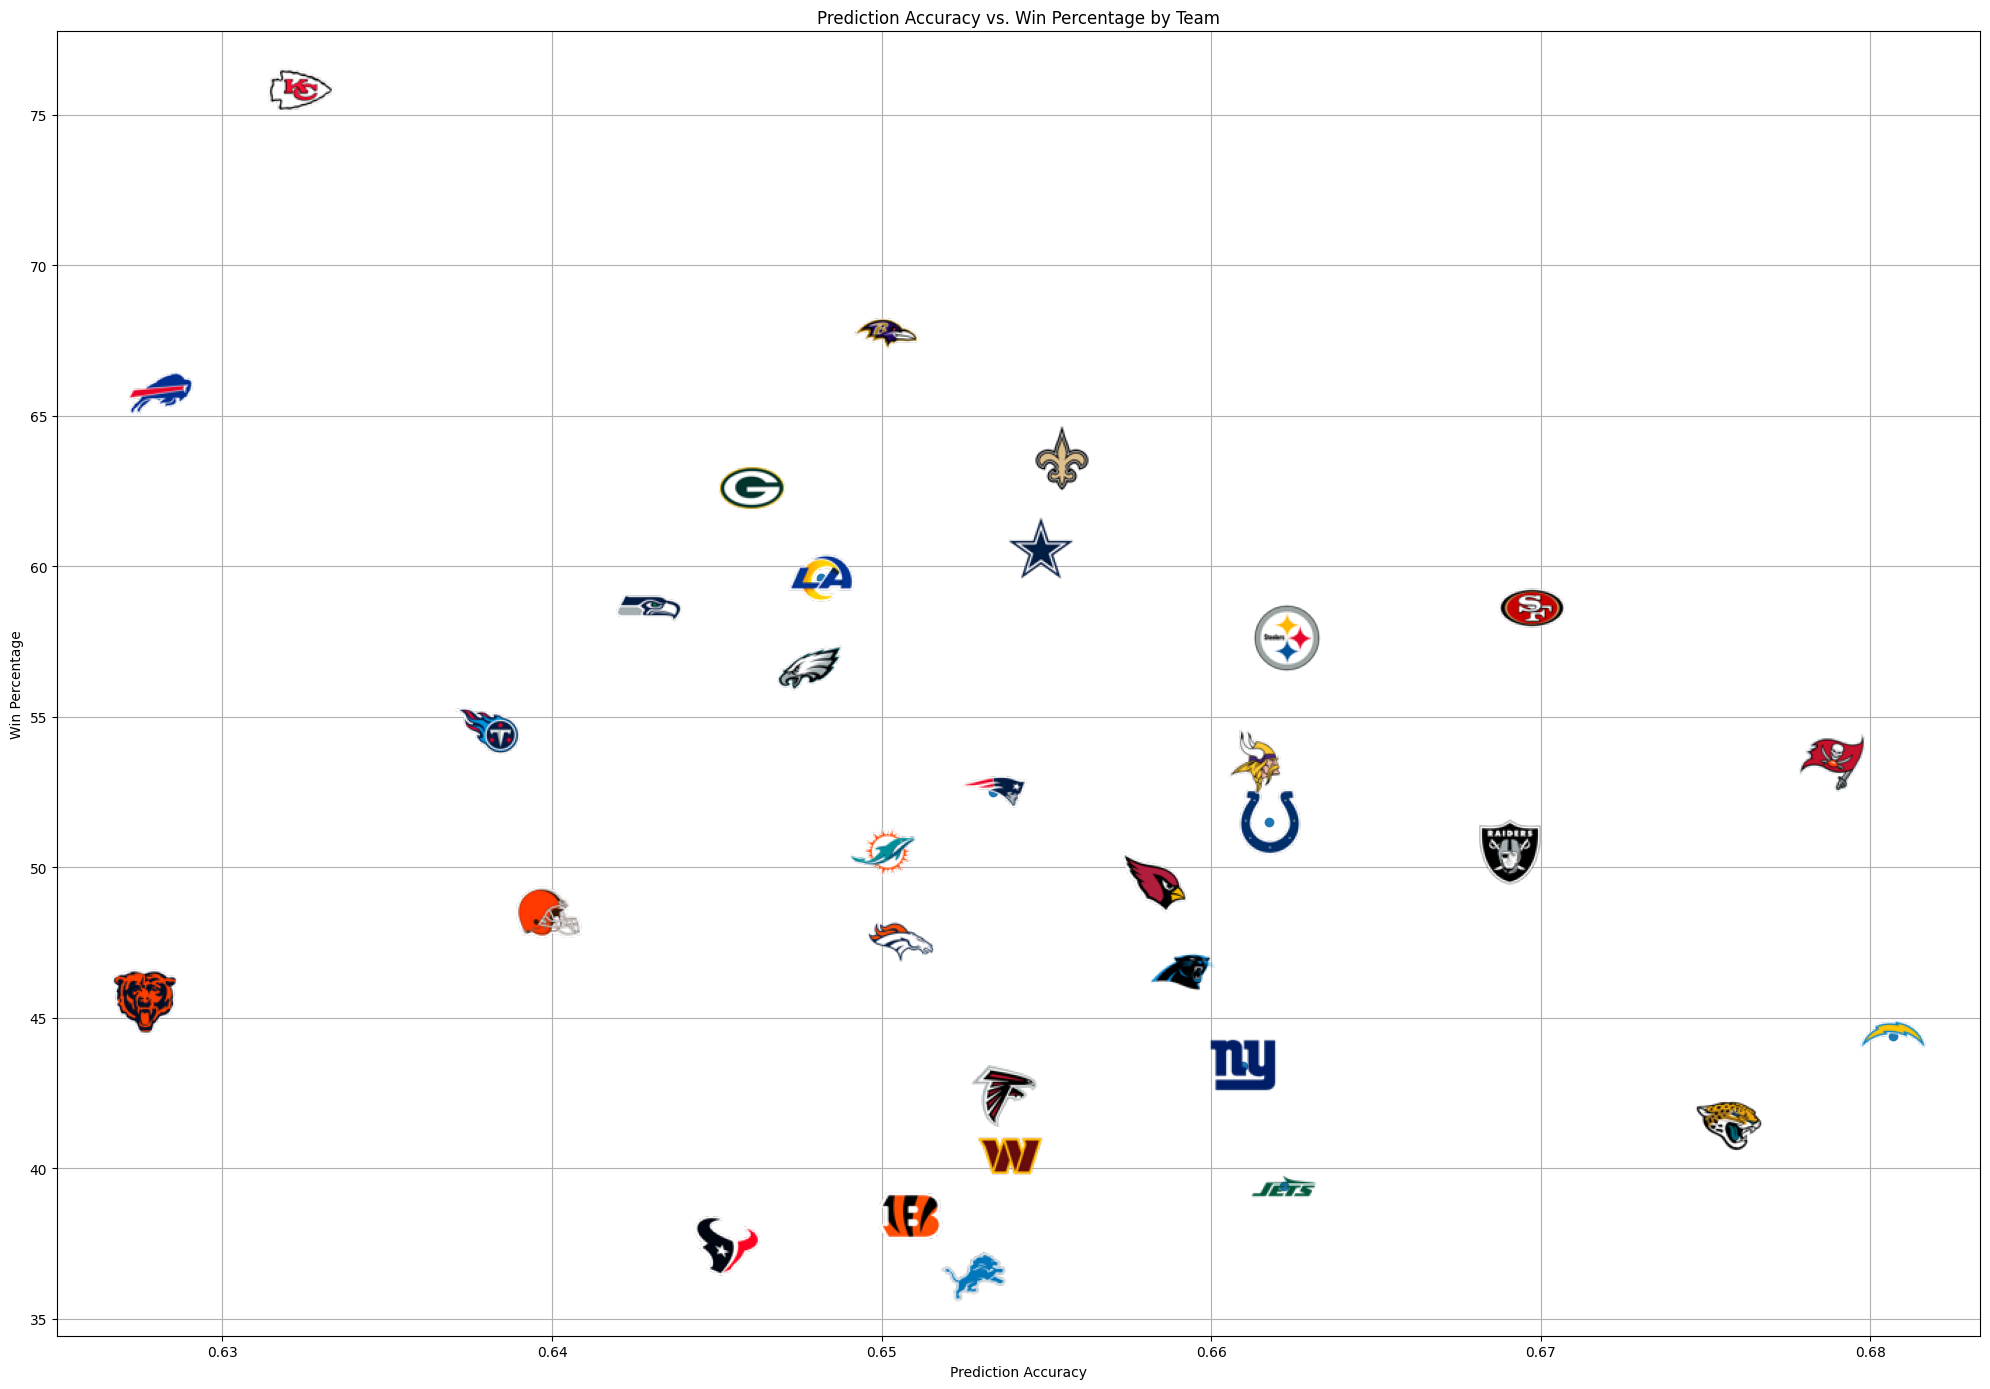

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import io

# Fetch team data to get logos
team_data = nfl.import_team_desc()

# get win percentage from 2018-2024 by team
win_percentage = {
    "KC": 75.8,
    "BAL": 67.7,
    "BUF": 65.7,
    "NO": 63.6,
    "GB": 62.6,
    "DAL": 60.6,
    "LA": 59.6,
    "SF": 58.6,
    "SEA": 58.6,
    "PIT": 57.6,
    "PHI": 56.6,
    "TEN": 54.5,
    "MIN": 53.5,
    "TB": 53.5,
    "NE": 52.5,
    "IND": 51.5,
    "MIA": 50.5,
    "LV": 50.5,
    "ARI": 49.5,
    "CLE": 48.5,
    "DEN": 47.5,
    "CAR": 46.5,
    "CHI": 45.5,
    "LAC": 44.4,
    "NYG": 43.4,
    "ATL": 42.4,
    "JAX": 41.4,
    "WAS": 40.4,
    "NYJ": 39.4,
    "CIN": 38.4,
    "HOU": 37.4,
    "DET": 36.4
}

# create dataframe with accuracy and win percentage
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['team_abbr', 'accuracy'])
team_win_percentage = pd.DataFrame(list(win_percentage.items()), columns=['team_abbr', 'win_percentage'])

merged_df = pd.merge(accuracy_df, team_win_percentage, on='team_abbr')
merged_df = pd.merge(merged_df, logo_df, on='team_abbr')

def getImage(path):
    img = Image.open(path)
    width, height = img.size
    print(f"Image size for {path}: {width}x{height} pixels")
    return OffsetImage(plt.imread(path, format="tif"), zoom=1)

plt.rcParams["figure.figsize"] = [20, 14]
plt.rcParams["figure.autolayout"] = True

# Define the x and y variables
x = merged_df['accuracy']
y = merged_df['win_percentage']

# Define the image paths
paths = merged_df['Logo Path']

# Define the plot
fig, ax = plt.subplots()

# Plot the scatter plot
scatter = ax.scatter(x, y)

# Add the logos to the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

# Set the labels
ax.set_xlabel('Prediction Accuracy')
ax.set_ylabel('Win Percentage')

# Set the title
ax.set_title('Prediction Accuracy vs. Win Percentage by Team')

plt.grid()
# Show the plot
plt.show()



Score differential: 0.2682
Time remaining: 0.2661
Position on field: 0.2477
Down: 0.2448
Quarter number: 0.2324
Yards to go: 0.2173


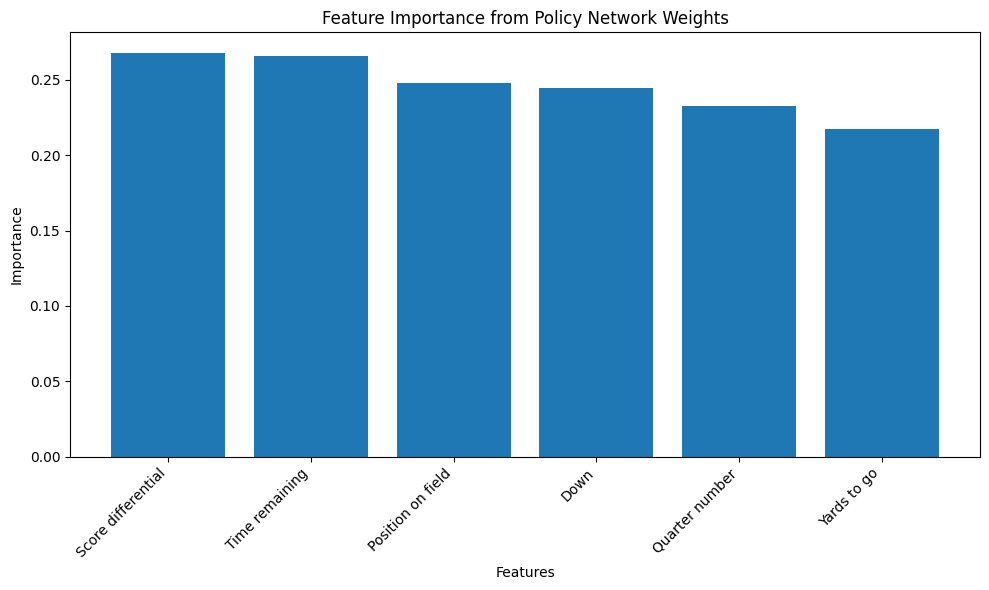

In [80]:
def get_feature_importance_from_weights(policy_net):
    # Get the weights of the first layer
    weights = policy_net.fc1.weight.data.abs().mean(dim=0)
    
    # Create a dictionary of feature importances
    feature_names = ['Down', 'Yards to go', 'Position on field', 'Score differential', 
                     'Quarter number', 'Time remaining', 'Team with posession', 'Team defending']
    importance_dict = dict(zip(feature_names, weights.tolist()))
    
    # Sort the dictionary by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_importance

feature_importance = get_feature_importance_from_weights(ppo_agent.policy_net)

# Print the feature importances
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")

# Visualize the feature importances
import matplotlib.pyplot as plt

features, importances = zip(*feature_importance)
plt.rcdefaults()
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.title("Feature Importance from Policy Network Weights")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

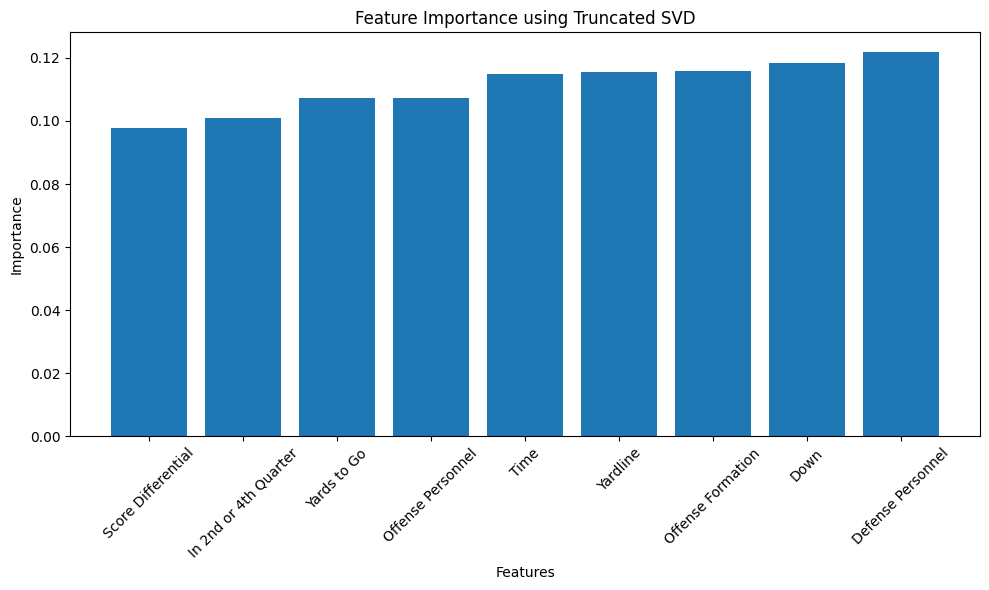

Least important features: ['Score Differential', 'In 2nd or 4th Quarter', 'Yards to Go']


In [104]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Assuming X is your feature matrix with shape (n_samples, 9)
# n_samples is the number of data points
feature_names = [
    'down', 
    'ydstogo', 
    'yardline_100_normalized', 
    'score_differential_normalized', 
    'qtr_clock_matters', 
    'time_normalized', 
    'offense_formation_normalized', 
    'offense_personnel_normalized', 
    'defense_personnel_normalized',
]

X = filtered_data[feature_names].values.astype(float)

# Perform Truncated SVD
svd = TruncatedSVD(n_components=9, random_state=42)
svd.fit(X)

# Get feature importances
feature_importances = np.sum(np.abs(svd.components_), axis=0)

# Normalize feature importances
feature_importances = feature_importances / np.sum(feature_importances)

map_names_readable = {
    'score_differential_normalized': "Score Differential",
    'yardline_100_normalized': "Yardline",
    'time_normalized': "Time",
    'ydstogo': "Yards to Go",
    'offense_personnel_normalized': "Offense Personnel",
    'down': "Down",
    'defense_personnel_normalized': "Defense Personnel",
    'offense_formation_normalized': "Offense Formation",
    'qtr_clock_matters': "In 2nd or 4th Quarter"
}

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_features = [map_names_readable[feature_names[i]] for i in sorted_idx]

# Plot feature importances with actual feature names
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Truncated SVD')
plt.tight_layout()
plt.show()

# Print the least important features
least_important = sorted_features[:3]  # Adjust the number as needed
print("Least important features:", least_important)


In [40]:
# view all columns 
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print(pbp_data.iloc[12])

play_id                                                                             278.0
game_id                                                                   2018_01_ATL_PHI
old_game_id_x                                                                  2018090600
home_team                                                                             PHI
away_team                                                                             ATL
season_type                                                                           REG
week                                                                                    1
posteam                                                                               ATL
posteam_type                                                                         away
defteam                                                                               PHI
side_of_field                                                                         PHI
yardline_1

In [82]:
play_types = []
run_locations = []
run_gaps = []
pass_locations = []
pass_lengths = []
offense_formations = {}
offense_personnel = {}
defense_personnel = {}
defenders_in_box = {}
defense_man_zone_type = {}

for i in range(100000):
    play = pbp_data.iloc[i]

    if play['play_type'] not in play_types:
        play_types.append(play['play_type'])
    
    if play['run_location'] not in run_locations:
        run_locations.append(play['run_location'])

    if play['run_gap'] not in run_gaps:
        run_gaps.append(play['run_gap'])
    
    if play['pass_location'] not in pass_locations:
        pass_locations.append(play['pass_location'])
    
    if play['pass_length'] not in pass_lengths:
        pass_lengths.append(play['pass_length'])


    if play['play_type'] not in ['run', 'pass']:
        continue

    if play['offense_formation'] not in offense_formations:
        offense_formations[play['offense_formation']] = 1
    else:
        offense_formations[play['offense_formation']] += 1
    
    if play['offense_personnel'] not in offense_personnel:
        offense_personnel[play['offense_personnel']] = 1
    else:
        offense_personnel[play['offense_personnel']] += 1

    if play['defense_personnel'] not in defense_personnel:
        defense_personnel[play['defense_personnel']] = 1
    else:
        defense_personnel[play['defense_personnel']] += 1

    if play['defenders_in_box'] not in defenders_in_box:
        defenders_in_box[play['defenders_in_box']] = 1
    else:
        defenders_in_box[play['defenders_in_box']] += 1
    
    if play['defense_man_zone_type'] not in defense_man_zone_type:
        defense_man_zone_type[play['defense_man_zone_type']] = 1
    else:
        defense_man_zone_type[play['defense_man_zone_type']] += 1
        
    
# run -> run_location + run_gap + play_type
# pass -> pass_location + pass_length + play_type

print(play_types, run_locations, run_gaps, pass_locations, pass_lengths)

[None, 'kickoff', 'no_play', 'pass', 'run', 'punt', 'field_goal', 'qb_kneel', 'extra_point', 'qb_spike'] [None, 'left', 'right', 'middle'] [None, 'end', 'guard', 'tackle'] [None, 'right', 'left', 'middle'] [None, 'short', 'deep']


In [83]:
print(defenders_in_box)

{7.0: 21108, 6.0: 28741, 10.0: 251, 8.0: 7353, 11.0: 197, 4.0: 2720, 5.0: 9257, 2.0: 38, 3.0: 343, 9.0: 771, nan: 1, nan: 1, nan: 1, nan: 1, 1.0: 11, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1}


In [9]:
data = nfl.import_ftn_data([2024])

data.iloc[1]

Downcasting floats.


ftn_game_id                                     6449
nflverse_game_id                      2024_01_BAL_KC
season                                          2024
week                                               1
ftn_play_id                                  1057996
nflverse_play_id                                  60
starting_hash                                      L
qb_location                                        S
n_offense_backfield                                1
n_defense_box                                      7
is_no_huddle                                   False
is_motion                                      False
is_play_action                                 False
is_screen_pass                                 False
is_rpo                                         False
is_trick_play                                  False
is_qb_out_of_pocket                            False
is_interception_worthy                         False
is_throw_away                                 